# Forward feature selection

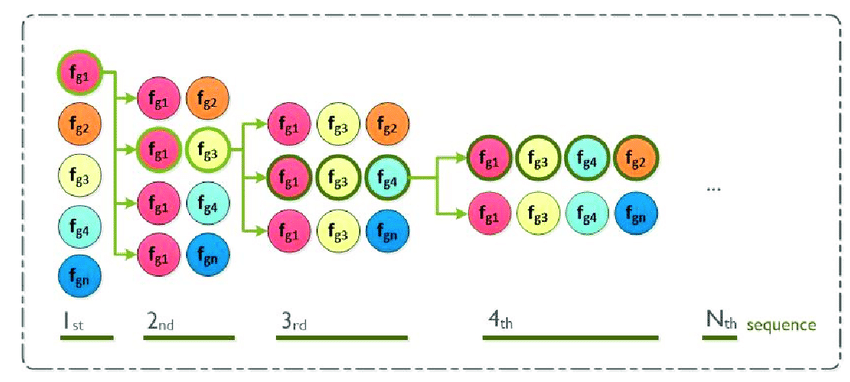

Reducing the number of features we use can have three benefits:

* Simplifies model explanation

* Model fit may be improved by the removal of features that add no value

* Model will be faster to fit

In this notebook we will use a model-based approach whereby we incrementally add features that most increase model performance (we could use simple accuracy, but in this case we will use ROC Area Under Curve as a more thorough analysis of performance).

Two key advantages of this method are:

* It is relatively simple.

*  It is tailored to the model in question.

Some key disadvantage of this method are:

* It may be slow if there are many parameters (though the loop to select features could be limited in the number of features to select).

* The selection of features may be dependent on model meta-parameters (such as level of regularisation).

* The selection of features may not transfer between models (e.g. a model that does not allow for feature interactions may not detect features which do not add much value independently).

We will go through the following steps:

* Download and save pre-processed data

* Split data into features (X) and label (y)

* Loop through features to select the feature that most increases ROC AUC

* Plot results

https://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination

In [3]:
import numpy as np
import pandas as pd
import hyperopt
import optuna

# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot as plt
from IPython.display import clear_output
import pickle
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectFromModel

In [7]:
#SMOTE = False
K_NEIGHBOURS = 5
N_SPLITS = 10
TUNE = True
directory = '../../Data/tidy_data/'

# Set up k-fold splits
number_of_splits = 10

In [25]:
FILENAME = 'ml_during_hypo_5.csv' #'ml_during_glyc_ts.csv'
df = pd.read_csv(directory + FILENAME)


df.day_of_week = df.day_of_week.astype(str)
df.day = df.day.astype(str)
df['season'] = (df.month%12 // 3 + 1).astype(str)
df = df.dropna(subset=['start_glc','duration']).reset_index(drop=True)

X = df.drop(columns=['y_hypo', 'stratify', 'bout_id', 'ID', 'month', ]) # 'day', 'day_of_week'
y = df['y_hypo']
strat = df['stratify']

In [27]:
X = pd.get_dummies(X)
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

## Logistic regression feature selection

In [ ]:
selected_features = ['start_glc',
                    'duration',
                    'intensity',
                    'form_of_exercise_aer',
                    'form_of_exercise_ana',
                    'form_of_exercise_mix',
                    'years_since_diagnosis',
                    'hba1c',
                    'cpep',
                    'time_of_day_morning',
                    'time_of_day_afternoon',
                    'time_of_day_evening',
                    'sex_male',
                    'sex_female',
                    'bmi',
                    'age']

X = X[selected_features]

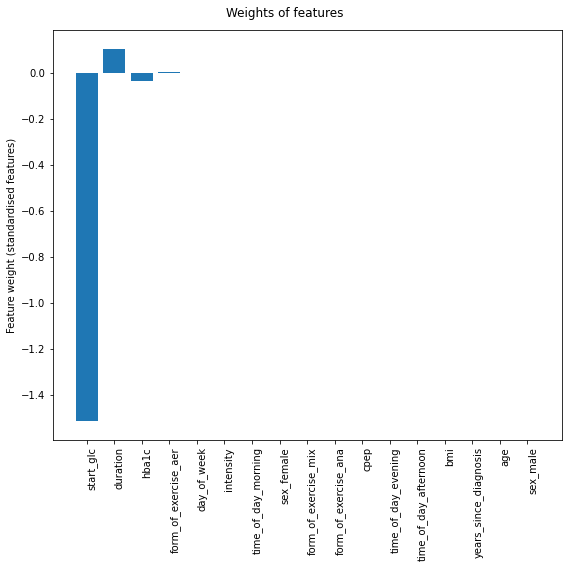

In [ ]:
weights, weights_fig = model_helper.calculate_coefficient(coeffs, X.columns)
weights_fig.savefig(fig_directory+'weights_'+period_str+'_lr_simple_features.svg')
weights.to_csv(weights_directory+'weights_'+period_str+'_lr_simple_features.csv',
               index=False)

In [ ]:
#%%capture

# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(X)
run = 0
number_of_features = len(list(X))

# Loop through feature list to select next feature
while len(available_features)> 0:

    # Track and pront progress
    run += 1
    print ('Feature run {} of {}'.format(run, number_of_features))
    
    # Convert DataFrames to NumPy arrays
    y_np = y.values
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''

    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        # Get data for features, and convert to NumPy array
        X_np = X[features_to_use].values
        
        # Set up lists to hold results for each selected features
        test_auc_results = []
    
        # Set up k-fold training/test splits
        number_of_splits = 5
        skf = StratifiedKFold(n_splits = number_of_splits)
        # Use strat column to stratify by both ID and y
        skf.get_n_splits(X_np, strat)
    
        # Loop through the k-fold splits
        for train_index, test_index in skf.split(X_np, y_np):
            
            # Get X and Y train/test
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            # Get X and Y train/test
            X_train_std, X_test_std = ml_helper.standardise_data(X_train, X_test)
    
            # Set up and fit model
            model = LogisticRegression
            best_params = tune.hyperopt_tune(model, params, None, X_train_std,
                                             y_train, 'roc_auc', 60)
            tuned_model = model(**best_params)
            
            tuned_model.fit(X_train_std, y_train)
    
            # Predict test set labels
            y_pred_test = tuned_model.predict(X_test_std)
            
            # Calculate accuracy of test sets
            accuracy_test = np.mean(y_pred_test == y_test)
          
            # Get ROC AUC
            probabilities = tuned_model.predict_proba(X_test_std)
            probabilities = probabilities[:, 1] 
            
            # Probability of having a hypo
            fpr, tpr, thresholds = roc_curve(y_test, probabilities)
            roc_auc = auc(fpr, tpr)
            test_auc_results.append(roc_auc)
            
            #clear_output()
        
        # Get average result from all k-fold splits
        feature_auc = np.mean(test_auc_results)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc > best_result:
            best_result = feature_auc
            best_feature = feature
    
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)

# Put results in DataFrame
results = pd.DataFrame()
results['feature to add'] = chosen_features
results['ROC AUC'] = roc_auc_by_feature_number

In [53]:
results

,feature to add,ROC AUC
0,start_glc,0.876492
1,duration,0.881285
2,hba1c,0.883433
3,form_of_exercise_aer,0.882297
4,time_of_day_morning,0.882669
5,sex_male,0.882452
6,time_of_day_evening,0.882152
7,sex_female,0.881956
8,bmi,0.881987
9,form_of_exercise_mix,0.881874


In [185]:
weights, weights_fig = model_helper.calculate_coefficient(coeffs, X_sub.columns)

ValueError: Shape of passed values is (2, 1), indices imply (7, 1)

## XGB with all the features

In [29]:
#%%capture

# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(X)
run = 0
number_of_features = len(list(X))

# Loop through feature list to select next feature
while len(available_features)> 0:

    # Track and pront progress
    run += 1
    print ('Feature run {} of {}'.format(run, number_of_features))
    
    # Convert DataFrames to NumPy arrays
    y_np = y.values
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''

    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        # Get data for features, and convert to NumPy array
        X_np = X[features_to_use].values
        
        # Set up lists to hold results for each selected features
        test_auc_results = []
    
        # Set up k-fold training/test splits
        number_of_splits = 5
        skf = StratifiedKFold(n_splits = number_of_splits)
        # Use strat column to stratify by both ID and y
        skf.get_n_splits(X_np, strat)
    
        # Loop through the k-fold splits
        for train_index, test_index in skf.split(X_np, y_np):
            
            # Get X and Y train/test
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            # Get X and Y train/test
            X_train_std, X_test_std = ml_helper.standardise_data(X_train, X_test)
    
            # Set up and fit model
            model = XGBClassifier(eval_metric='logloss')

            # Fit to training data
            model.fit(X_train_std, y_train)
    
            # Predict test set labels
            y_pred_test = model.predict(X_test_std)
            
            # Calculate accuracy of test sets
            accuracy_test = np.mean(y_pred_test == y_test)
          
            # Get ROC AUC
            probabilities = model.predict_proba(X_test_std)
            probabilities = probabilities[:, 1] 
            
            # Probability of having a hypo
            fpr, tpr, thresholds = roc_curve(y_test, probabilities)
            roc_auc = auc(fpr, tpr)
            test_auc_results.append(roc_auc)
            
            #clear_output()
        
        # Get average result from all k-fold splits
        feature_auc = np.mean(test_auc_results)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc > best_result:
            best_result = feature_auc
            best_feature = feature
    
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)

# Put results in DataFrame
results = pd.DataFrame()
results['feature to add'] = chosen_features
results['ROC AUC'] = roc_auc_by_feature_number

Feature run 1 of 237
Feature run 2 of 237
Feature run 3 of 237
Feature run 4 of 237
Feature run 5 of 237
Feature run 6 of 237
Feature run 7 of 237
Feature run 8 of 237
Feature run 9 of 237
Feature run 10 of 237
Feature run 11 of 237
Feature run 12 of 237
Feature run 13 of 237
Feature run 14 of 237
Feature run 15 of 237
Feature run 16 of 237
Feature run 17 of 237
Feature run 18 of 237
Feature run 19 of 237
Feature run 20 of 237
Feature run 21 of 237
Feature run 22 of 237
Feature run 23 of 237
Feature run 24 of 237
Feature run 25 of 237
Feature run 26 of 237
Feature run 27 of 237
Feature run 28 of 237
Feature run 29 of 237
Feature run 30 of 237
Feature run 31 of 237
Feature run 32 of 237
Feature run 33 of 237
Feature run 34 of 237
Feature run 35 of 237
Feature run 36 of 237
Feature run 37 of 237
Feature run 38 of 237
Feature run 39 of 237
Feature run 40 of 237
Feature run 41 of 237
Feature run 42 of 237
Feature run 43 of 237
Feature run 44 of 237
Feature run 45 of 237
Feature run 46 of 2

In [31]:
results.to_csv('forward_feature_results.csv')

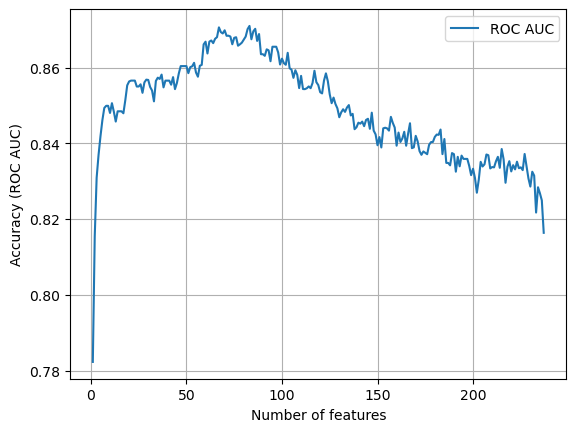

In [32]:
chart_x = list(range(1, number_of_features+1))

plt.plot(chart_x, roc_auc_by_feature_number,
        label = 'ROC AUC')

plt.xlabel('Number of features')
plt.ylabel('Accuracy (ROC AUC)')
plt.legend()
plt.grid(True)

plt.show()

In [35]:
results.sort_values('ROC AUC', ascending=False)

,feature to add,ROC AUC
82,day_of_week_1,0.870981
66,"before_glc__agg_linear_trend__attr_""rvalue""__c...",0.870599
85,before_TIR_hyper,0.870219
81,"before_glc__fft_coefficient__attr_""angle""__coe...",0.870139
69,before_TIR_hyper_exercise,0.869824
...,...,...
235,"before_glc__fft_coefficient__attr_""imag""__coeff_5",0.824947
232,before_glc__energy_ratio_by_chunks__num_segmen...,0.821729
236,"before_glc__change_quantiles__f_agg_""mean""__is...",0.816382
1,duration,0.815426


In [44]:
selected_features = results.loc[:83,'feature to add'].values

selected_features_66 = results.loc[:67,'feature to add'].values

In [45]:
with open("features_xgb_during_ts", "wb") as fp:   #Pickling 
    pickle.dump(selected_cols, fp)

In [ ]:
with open("features_xgb_66", "wb") as fp:   #Pickling 
    pickle.dump(selected_features_66, fp)

## XGB with a few features

In [54]:
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(X)
run = 0
number_of_features = len(list(X))

# Loop through feature list to select next feature
while len(available_features)> 0:

    # Track and pront progress
    run += 1
    print ('Feature run {} of {}'.format(run, number_of_features))
    
    # Convert DataFrames to NumPy arrays
    y_np = y.values
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''

    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        # Get data for features, and convert to NumPy array
        X_np = X[features_to_use].values
        
        # Set up lists to hold results for each selected features
        test_auc_results = []
    
        # Set up k-fold training/test splits
        number_of_splits = 5
        skf = StratifiedKFold(n_splits = number_of_splits)
        skf.get_n_splits(X_np, y)
    
        # Loop through the k-fold splits
        for train_index, test_index in skf.split(X_np, y_np):
            
            # Get X and Y train/test
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            # Get X and Y train/test
            X_train_std, X_test_std = ml_helper.standardise_data(X_train, X_test)
    
            # Set up and fit model
            pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
            study = optuna.create_study(direction="maximize")
            study.optimize(lambda trial: tune.xgb_objective(trial, X_train, y_train), n_trials=100) # , timeout=600
            clear_output()
            best_params = study.best_params
            tuned_model = XGBClassifier(**best_params)
            
            tuned_model.fit(X_train_std,y_train)
    
            # Predict test set labels
            y_pred_test = tuned_model.predict(X_test_std)
            
            # Calculate accuracy of test sets
            accuracy_test = np.mean(y_pred_test == y_test)
          
            # Get ROC AUC
            probabilities = tuned_model.predict_proba(X_test_std)
            probabilities = probabilities[:, 1] # Probability of 'survived'
            fpr, tpr, thresholds = roc_curve(y_test, probabilities)
            roc_auc = auc(fpr, tpr)
            test_auc_results.append(roc_auc)
            
            clear_output()
        
        # Get average result from all k-fold splits
        feature_auc = np.mean(test_auc_results)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc > best_result:
            best_result = feature_auc
            best_feature = feature
    
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)

# Put results in DataFrame
results = pd.DataFrame()
results['feature to add'] = chosen_features
results['ROC AUC'] = roc_auc_by_feature_number

In [55]:
results

,feature to add,ROC AUC
0,start_glc,0.873456
1,duration,0.884631
2,time_of_day_afternoon,0.888122
3,form_of_exercise_ana,0.885509
4,form_of_exercise_aer,0.889630
5,intensity,0.889527
6,cpep,0.889713
7,form_of_exercise_mix,0.891407
8,bmi,0.887224
9,time_of_day_evening,0.884476


In [167]:
X_sub = X[['start_glc', 'duration',]]

In [181]:
X_sub = X[['start_glc', 'duration', 'form_of_exercise_aer',
      'intensity','form_of_exercise_ana', 'time_of_day_afternoon',
       'cpep']]

In [182]:
X_test, observed, predicted, predicted_proba, list_shap_values = model_helper.run_k_fold_xgb(X_sub, y, strat, number_of_splits= N_SPLITS, by_id=False, smote=SMOTE, tune_hp=TUNE)
#clear_output()#wait=True)

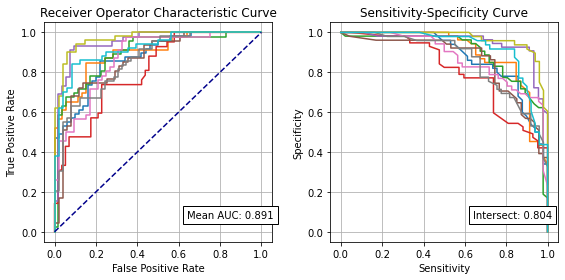

In [183]:
log_threshold_curves, mean_auc, sens_spec = ml_helper.k_fold_threshold_curves(observed, predicted_proba)

In [170]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)

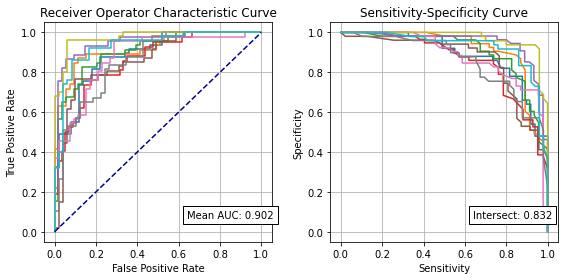

In [179]:
log_threshold_curves, mean_auc, sens_spec = ml_helper.k_fold_threshold_curves(observed, predicted_proba)

In [180]:
mean_accuracy

,mean
observed_positive_rate,0.477242
observed_negative_rate,0.522758
predicted_positive_rate,0.441651
predicted_negative_rate,0.558349
accuracy,0.804071
precision,0.817540
recall,0.756193
f1,0.783647
sensitivity,0.756193
specificity,0.846982


## Hypers

In [114]:
df = pd.read_csv(directory + FILENAME)
df.day_of_week = df.day_of_week.astype(str)
df['season']=df.month%12 // 3 + 1
#df.month = df.month.astype(str) # let's have a nosey
df.season = df.season.astype(str)

In [115]:
strat = df['ID'].astype(str) + '_' + df[target_columns[1]].astype(str)
df.drop(columns=['ID', 'month', 'day', 'season', 'day_of_week'], inplace=True)

In [116]:
X = df.drop(columns=target_columns)
X = pd.get_dummies(X)
imputer = KNNImputer(n_neighbors=K_NEIGHBOURS)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [117]:
#X = X[['start_glc', 'duration', 'form_of_exercise_aer',
#       'years_since_diagnosis', 'hba1c']]
y = df[target_columns[1]]

In [118]:
# Define hyperparameter space
params = {'penalty' : hyperopt.hp.choice('penalty', ['l2', 'l1']), # , 'l1'
          'C' : hyperopt.hp.loguniform('C', -4, 4), #20
          'solver' : hyperopt.hp.choice('solver', ['lbfgs', 'liblinear']), #'max_iter': [1000] 'liblinear',
         }

In [119]:
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(X)
run = 0
number_of_features = len(list(X))

# Loop through feature list to select next feature
while len(available_features)> 0:

    # Track and pront progress
    run += 1
    print ('Feature run {} of {}'.format(run, number_of_features))
    
    # Convert DataFrames to NumPy arrays
    y_np = y.values
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''

    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        # Get data for features, and convert to NumPy array
        X_np = X[features_to_use].values
        
        # Set up lists to hold results for each selected features
        test_auc_results = []
    
        # Set up k-fold training/test splits
        number_of_splits = 5
        skf = StratifiedKFold(n_splits = number_of_splits)
        skf.get_n_splits(X_np, y)
    
        # Loop through the k-fold splits
        for train_index, test_index in skf.split(X_np, y_np):
            
            # Get X and Y train/test
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            # Get X and Y train/test
            X_train_std, X_test_std = ml_helper.standardise_data(X_train, X_test)
    
            # Set up and fit model
            #model = XGBClassifier()
            model = LogisticRegression
            best_params = tune.hyperopt_tune(model, params, None, X_train_std,
                                             y_train, 'roc_auc', 60)
            tuned_model = model(**best_params)
            
            tuned_model.fit(X_train_std,y_train)
    
            # Predict test set labels
            y_pred_test = tuned_model.predict(X_test_std)
            
            # Calculate accuracy of test sets
            accuracy_test = np.mean(y_pred_test == y_test)
          
            # Get ROC AUC
            probabilities = tuned_model.predict_proba(X_test_std)
            probabilities = probabilities[:, 1] # Probability of 'survived'
            fpr, tpr, thresholds = roc_curve(y_test, probabilities)
            roc_auc = auc(fpr, tpr)
            test_auc_results.append(roc_auc)
            
            #clear_output()
        
        # Get average result from all k-fold splits
        feature_auc = np.mean(test_auc_results)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc > best_result:
            best_result = feature_auc
            best_feature = feature
    
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)

# Put results in DataFrame
results = pd.DataFrame()
results['feature to add'] = chosen_features
results['ROC AUC'] = roc_auc_by_feature_number

Feature run 1 of 16
100%|███████████████████████████████████████████████| 60/60 [00:01<00:00, 33.13trial/s, best loss: -0.5397161917684306]
Feature run 2 of 16
100%|████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.79trial/s, best loss: -0.966358693131081]
Feature run 3 of 16
100%|███████████████████████████████████████████████| 60/60 [00:01<00:00, 35.63trial/s, best loss: -0.9679995999025849]
Feature run 4 of 16
100%|███████████████████████████████████████████████| 60/60 [00:02<00:00, 28.25trial/s, best loss: -0.9698903501142306]
Feature run 5 of 16
100%|███████████████████████████████████████████████| 60/60 [00:02<00:00, 29.55trial/s, best loss: -0.9698903501142306]
Feature run 6 of 16
100%|███████████████████████████████████████████████| 60/60 [00:02<00:00, 28.89trial/s, best loss: -0.9692430910714492]
Feature run 7 of 16
100%|███████████████████████████████████████████████| 60/60 [00:02<00:00, 27.80trial/s, best loss: -0.9688680722262811]
Feature run 8 of 16


In [120]:
results

,feature to add,ROC AUC
0,start_glc,0.968914
1,duration,0.971699
2,intensity,0.972748
3,sex_female,0.973007
4,years_since_diagnosis,0.973049
5,sex_male,0.972930
6,cpep,0.973129
7,time_of_day_evening,0.973288
8,hba1c,0.972251
9,form_of_exercise_ana,0.972293


In [121]:
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(X)
run = 0
number_of_features = len(list(X))

# Loop through feature list to select next feature
while len(available_features)> 0:

    # Track and pront progress
    run += 1
    print ('Feature run {} of {}'.format(run, number_of_features))
    
    # Convert DataFrames to NumPy arrays
    y_np = y.values
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''

    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        # Get data for features, and convert to NumPy array
        X_np = X[features_to_use].values
        
        # Set up lists to hold results for each selected features
        test_auc_results = []
    
        # Set up k-fold training/test splits
        number_of_splits = 5
        skf = StratifiedKFold(n_splits = number_of_splits)
        skf.get_n_splits(X_np, y)
    
        # Loop through the k-fold splits
        for train_index, test_index in skf.split(X_np, y_np):
            
            # Get X and Y train/test
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            # Get X and Y train/test
            X_train_std, X_test_std = ml_helper.standardise_data(X_train, X_test)
    
            # Set up and fit model
            pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
            study = optuna.create_study(direction="maximize")
            study.optimize(lambda trial: tune.xgb_objective(trial, X_train, y_train), n_trials=100) # , timeout=600
            clear_output()
            best_params = study.best_params
            tuned_model = XGBClassifier(**best_params)
            
            tuned_model.fit(X_train_std,y_train)
    
            # Predict test set labels
            y_pred_test = tuned_model.predict(X_test_std)
            
            # Calculate accuracy of test sets
            accuracy_test = np.mean(y_pred_test == y_test)
          
            # Get ROC AUC
            probabilities = tuned_model.predict_proba(X_test_std)
            probabilities = probabilities[:, 1] # Probability of 'survived'
            fpr, tpr, thresholds = roc_curve(y_test, probabilities)
            roc_auc = auc(fpr, tpr)
            test_auc_results.append(roc_auc)
            
            clear_output()
        
        # Get average result from all k-fold splits
        feature_auc = np.mean(test_auc_results)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc > best_result:
            best_result = feature_auc
            best_feature = feature
    
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)

# Put results in DataFrame
results = pd.DataFrame()
results['feature to add'] = chosen_features
results['ROC AUC'] = roc_auc_by_feature_number

In [122]:
results

,feature to add,ROC AUC
0,start_glc,0.962885
1,form_of_exercise_mix,0.966308
2,duration,0.967343
3,sex_male,0.970408
4,cpep,0.972889
5,time_of_day_evening,0.971970
6,form_of_exercise_ana,0.970227
7,age,0.970183
8,hba1c,0.971607
9,intensity,0.971634


FILENAME = 'ml_during_glyc.csv'
df = pd.read_csv(directory + FILENAME)
df.day_of_week = df.day_of_week.astype(str)
df['season']=df.month%12 // 3 + 1
#df.month = df.month.astype(str) # let's have a nosey
df.ID = df.ID.astype(str)

df.drop(columns=['ID', 'month'], inplace=True)
target_columns = ['y_hypo']#, 'y_hyper']
strat = df['stratify']

X = df.drop(columns=target_columns+['stratify'])
y = df[target_columns[0]]

X = pd.get_dummies(X)
imputer = KNNImputer(n_neighbors=K_NEIGHBOURS)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

### 4.1.1. Logistic regression

In [126]:
SMOTE = False
K_NEIGHBOURS = 5
N_SPLITS = 10
TUNE = True

In [128]:
X = X[['start_glc','duration']]

In [129]:
test_indices, observed, predicted, predicted_proba, coeffs, list_shap_values = model_helper.run_k_fold_model(X, y, LogisticRegression, params, strat, number_of_splits=10, smote=SMOTE)

100%|███████████████████████████████████████████████| 60/60 [00:02<00:00, 29.65trial/s, best loss: -0.9739400424137266]


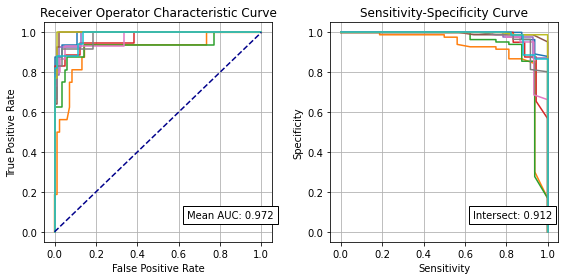

In [131]:
# glyc only
log_threshold_curves, mean_auc, sens_spec = ml_helper.k_fold_threshold_curves(observed, predicted_proba)

In [132]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)

In [133]:
mean_accuracy

,mean
observed_positive_rate,0.153257
observed_negative_rate,0.846743
predicted_positive_rate,0.153257
predicted_negative_rate,0.846743
accuracy,0.949330
precision,0.837448
recall,0.837448
f1,0.837448
sensitivity,0.837448
specificity,0.969914


In [134]:
X_test, observed, predicted, predicted_proba, list_shap_values = model_helper.run_k_fold_xgb(X, y, strat, number_of_splits= N_SPLITS, by_id=False, smote=SMOTE, tune_hp=TUNE)
#clear_output()#wait=True)

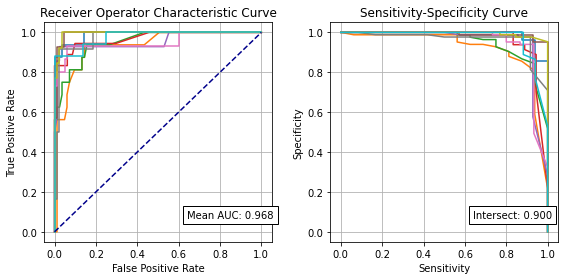

In [137]:
log_threshold_curves, mean_auc, sens_spec = ml_helper.k_fold_threshold_curves(observed, predicted_proba)

In [138]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)

In [139]:
mean_accuracy

,mean
observed_positive_rate,0.153257
observed_negative_rate,0.846743
predicted_positive_rate,0.173665
predicted_negative_rate,0.826335
accuracy,0.935044
precision,0.759614
recall,0.860483
f1,0.801170
sensitivity,0.860483
specificity,0.949767


## Other shit

In [22]:
results['feature to add'].values

array(['start_glc', 'duration', 'form_of_exercise_aer',
       'years_since_diagnosis', 'hba1c', 'intensity',
       'time_of_day_evening', 'bmi', 'form_of_exercise_ana',
       'form_of_exercise_mix', 'time_of_day_afternoon',
       'time_of_day_morning', 'cpep', 'age', 'sex_female', 'sex_male'],
      dtype=object)

In [57]:
results#.sort_values('ROC AUC', ascending=False)

,feature to add,ROC AUC
0,start_glc,0.873456
1,duration,0.884631
2,time_of_day_afternoon,0.888122
3,form_of_exercise_ana,0.885509
4,form_of_exercise_aer,0.889630
5,intensity,0.889527
6,cpep,0.889713
7,form_of_exercise_mix,0.891407
8,bmi,0.887224
9,time_of_day_evening,0.884476


In [117]:
# k-fold feature importance
thresholds = []

 # Set up k-fold training/test splits
number_of_splits = 5
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X, y)

# Loop through the k-fold splits
for train_index, test_index in skf.split(X, y):

    # Get X and Y train/test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # fit model on all training data
    model = XGBClassifier()
    model.fit(X_train, y_train)
    # make predictions for test data and evaluate
    predictions = model.predict_proba(X_test)[:,1]
    roc = roc_auc_score(y_test, predictions)
    print("Roc: %.2f%%" % (roc))
    # Fit model using each importance as a threshold
    fold_thresholds = model.feature_importances_
    thresholds.append(fold_thresholds)

[14:20:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Roc: 0.91%
[14:21:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Roc: 0.86%
[14:21:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Roc: 0.84%
[14:21:01] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if

In [118]:
mean_thresholds = thresholds[0]
for i in range(1,len(thresholds)):
    mean_thresholds = mean_thresholds + thresholds[i]
mean_thresholds = sort(mean_thresholds/len(thresholds))

In [121]:
thresholds[3]

array([0.        , 0.01176153, 0.00951999, 0.00155779, 0.        ,
       0.00392267, 0.00108163, 0.01912748, 0.00645288, 0.00144545,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00285794, 0.003112  ,
       0.00169183, 0.00249984, 0.00100719, 0.00298894, 0.        ,
       0.        , 0.00172891, 0.        , 0.00188886, 0.00321063,
       0.00523246, 0.05063064, 0.00175078, 0.00422426, 0.00305662,
       0.00342761, 0.00267811, 0.        , 0.02438727, 0.        ,
       0.00057665, 0.00744106, 0.00633203, 0.        , 0.        ,
       0.        , 0.00507879, 0.00604111, 0.00014877, 0.00133925,
       0.        , 0.        , 0.00323719, 0.00225269, 0.0010895 ,
       0.00136431, 0.00439227, 0.00550339, 0.        , 0.        ,
       0.        , 0.00055106, 0.00024461, 0.00015076, 0.        ,
       0.00228246, 0.00054126, 0.00033782, 0.00742861, 0.00218853,
       0.0020289 , 0.00069157, 0.00200372, 0.00203358, 0.     

In [119]:
sort(mean_thresholds)

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       2.4807403e-05, 9.2603113e-05, 1.2201311e-04, 1.4553152e-04,
       1.7821041e-04, 2.0421520e-04, 2.3708488e-04, 2.5769960e-04,
       3.4623471e-04, 3.5140055e-04, 3.5446422e-04, 3.6158794e-04,
       4.2970394e-04, 4.5851548e-04, 4.8149918e-04, 4.9150048e-04,
       4.9728854e-04, 5.4547004e-04, 7.8151998e-04, 8.1732019e-04,
       8.5373706e-04, 8.6475525e-04, 8.6866005e-04, 8.8158331e-04,
       8.9039432e-04, 9.0369058e-04, 9.1344363e-04, 9.4012078e-04,
       9.5615600e-04, 9.7568036e-04, 9.8710356e-04, 9.9498383e-04,
       1.0169239e-03, 1.1024295e-03, 1.1167353e-03, 1.1615809e-03,
       1.1777276e-03, 1.2615257e-03, 1.2897577e-03, 1.3064449e

In [ ]:
results=[]
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
# fit model on all training data
model = XGBClassifier()
model.fit(X_train, y_train)
for thresh in mean_thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict_proba(select_X_test)[:,1]
    accuracy = roc_auc_score(y_test, predictions)
    results.append([thresh, select_X_train.shape[1], accuracy])

In [132]:
selected_cols=X.columns[mean_thresholds>=0.001148]

In [133]:
selected_cols

Index(['sex_female', 'sex_male'], dtype='object')

In [171]:
with open("features_xgb_during_ts", "wb") as fp:   #Pickling 
    pickle.dump(selected_cols, fp)

In [134]:
features = pd.DataFrame(X.columns, columns=['cols'])
features['thresh'] = mean_thresholds

In [135]:
features.sort_values('thresh', ascending=False)

,cols,thresh
287,sex_male,0.010655
286,sex_female,0.002495
285,form_of_exercise_mix,0.002149
284,form_of_exercise_ana,0.002131
283,form_of_exercise_aer,0.001985
282,time_of_day_morning,0.001848
281,time_of_day_evening,0.001762
280,time_of_day_afternoon,0.001679
279,before_glc__partial_autocorrelation__lag_1,0.001665
278,"before_glc__change_quantiles__f_agg_""mean""__is...",0.001640


In [85]:
features[features.thresh>=0.001148].sort_values('thresh', ascending=False).to_csv('features_xgb_during_ts.csv')

In [69]:
thresholds = sort(model.feature_importances_)

In [184]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# fit model on all training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
predictions = model.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, predictions)
print("Accuracy: %.2f%%" % (roc * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)

[16:34:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 89.91%


In [186]:
thresholds

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

<Figure size 360x360 with 0 Axes>

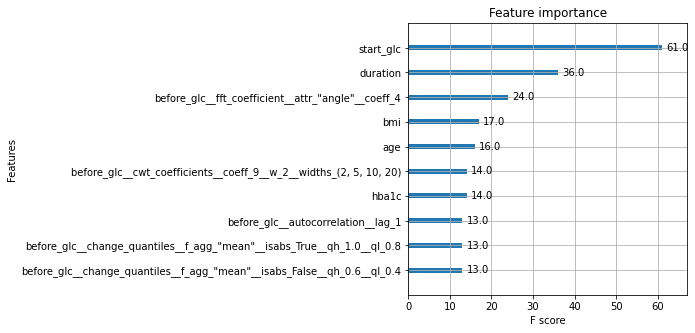

In [185]:
plt.figure(figsize=(5,5))
plot_importance(model,max_num_features=10)
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

In [172]:
results = []
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict_proba(select_X_test)[:,1]
    roc = roc_auc_score(y_test, predictions)
    results.append([thresh, select_X_train.shape[1], roc])

[16:24:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 89.91%
[16:24:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to r

In [174]:
pd.DataFrame(results, columns=['thresh', 'n', 'roc']).drop_duplicates()#.sort_values('accuracy',ascending=False)

,thresh,n,roc
0,0.000000,288,0.899112
79,0.000095,209,0.899112
80,0.000129,208,0.898031
81,0.000160,207,0.900463
82,0.000193,206,0.900463
83,0.000211,205,0.900347
84,0.000217,204,0.900347
85,0.000246,203,0.900154
86,0.000281,202,0.900154
87,0.000311,201,0.900154


In [173]:
pd.DataFrame(results, columns=['thresh', 'n', 'roc']).drop_duplicates().sort_values('accuracy',ascending=False)

,thresh,n,accuracy
172,0.002623,116,0.905483
159,0.002117,129,0.905444
168,0.002498,120,0.905328
173,0.002650,115,0.905135
174,0.002653,114,0.904942
169,0.002514,119,0.904710
138,0.001648,150,0.904402
184,0.003040,104,0.904286
127,0.001148,161,0.903784
167,0.002443,121,0.903745


## LR

In [163]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
X_train, X_test = ml_helper.standardise_data(X_train, X_test)
# fit model on all training data
model = LogisticRegression()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
predictions = model.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, predictions)
print("Accuracy: %.2f%%" % (roc * 100.0))
# Fit model using each importance as a threshold
thresholds = abs(sort(model.coef_[0]))
results = []
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = LogisticRegression()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict_proba(select_X_test)[:,1]
    roc = roc_auc_score(y_test, predictions)
    results.append([thresh, select_X_train.shape[1], roc])

Accuracy: 86.57%


In [162]:
pd.DataFrame(results, columns=['thresh', 'n', 'roc']).drop_duplicates().sort_values('accuracy',ascending=False)

,thresh,n,accuracy
266,0.551398,48,0.875598
260,0.437167,63,0.874247
267,0.574718,44,0.873900
261,0.439035,61,0.873784
265,0.521254,50,0.873205
264,0.495338,53,0.872625
244,0.317056,105,0.872587
245,0.323485,104,0.872239
262,0.465105,58,0.872046
246,0.325059,103,0.872008


In [168]:
selected_cols=X.columns[thresholds>=0.8498]

In [170]:
selected_cols

Index(['before_TIR_lv2_hypo', 'before_TIR_lv1_hypo', 'before_TIR_hypo',
       'before_TIR_norm', 'before_TIR_hyper', 'before_TIR_lv1_hyper',
       'before_TIR_lv2_hyper', 'before_glc__approximate_entropy__m_2__r_0.9',
       'before_glc__approximate_entropy__m_2__r_0.5',
       'before_glc__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6',
       'before_glc__partial_autocorrelation__lag_1', 'time_of_day_afternoon',
       'time_of_day_evening', 'time_of_day_morning', 'form_of_exercise_aer',
       'form_of_exercise_ana', 'form_of_exercise_mix', 'sex_female',
       'sex_male'],
      dtype='object')

In [175]:
xgb = XGBClassifier()
xgb.fit(X,y)

[16:25:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<Figure size 360x360 with 0 Axes>

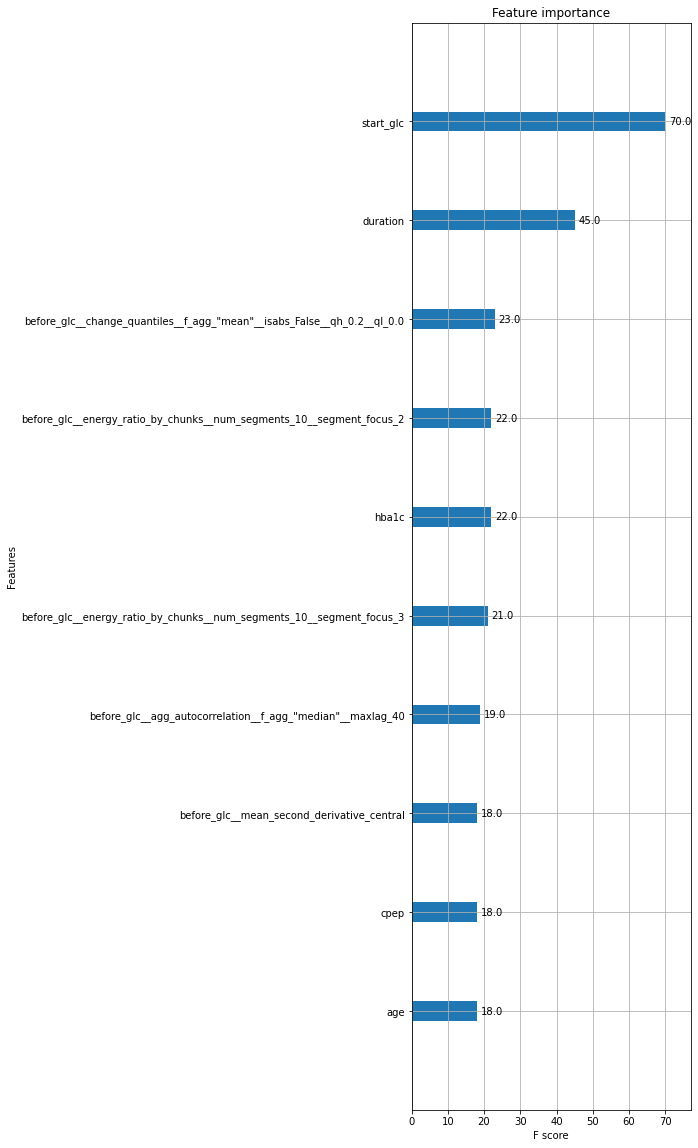

In [183]:
plt.figure(figsize=(5,5))
plot_importance(xgb,max_num_features=10)
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

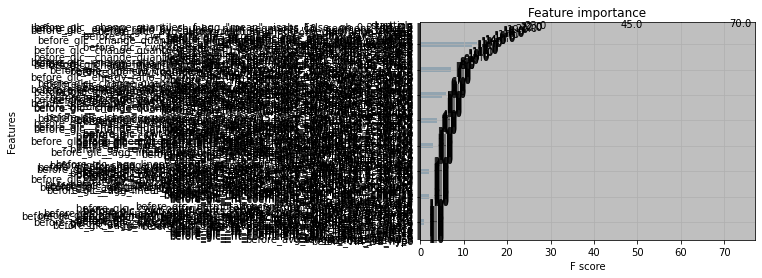

In [176]:
plot_importance(xgb)

In [13]:
results

,feature to add,ROC AUC
0,start_glc,0.863634
1,before_TIR_lv2_hypo,0.868886
2,before_number_lv2_hypos,0.868886
3,form_of_exercise_ana,0.867886
4,time_of_day_evening,0.863568
5,before_number_lv1_hypos,0.860458
6,duration,0.858591
7,before_maximum_glucose,0.870520
8,cpep,0.881085
9,before_TIR_hyper_exercise,0.886819


In [8]:
results = pd.read_csv('../../Data/tidy_data/feature_selection_results.csv')

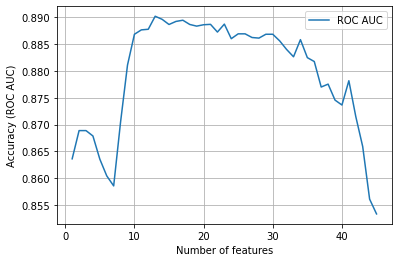

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

chart_x = list(range(1, number_of_features+1))

plt.plot(chart_x, results['ROC AUC'],
        label = 'ROC AUC')

plt.xlabel('Number of features')
plt.ylabel('Accuracy (ROC AUC)')
plt.legend()
plt.grid(True)

plt.show()

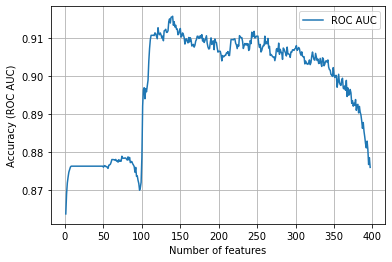

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

chart_x = list(range(1, number_of_features+1))

plt.plot(chart_x, results['ROC AUC'],
        label = 'ROC AUC')

plt.xlabel('Number of features')
plt.ylabel('Accuracy (ROC AUC)')
plt.legend()
plt.grid(True)

plt.show()